In [1]:
from PIL import Image, ImageDraw, ImageFont
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
##https://www.kaggle.com/code/anokas/kuzushiji-visualisation/notebook

In [2]:
# From https://www.google.com/get/noto/
fontsize = 30
!wget -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
!unzip -p NotoSansCJKjp-hinted.zip NotoSansCJKjp-Regular.otf > NotoSansCJKjp-Regular.otf
!rm NotoSansCJKjp-hinted.zip

font = ImageFont.truetype('./NotoSansCJKjp-Regular.otf', fontsize, encoding='utf-8')

NotoSansCJKjp-hinte 100%[===================>] 115.49M  88.3MB/s    in 1.3s    


In [3]:
df_train = pd.read_csv('data/train.csv')
#df_train = pd.read_csv('data/cropped.csv')

unicode_map = {codepoint: char for codepoint, char in pd.read_csv('data/unicode_translation.csv').values}

In [4]:
unicode_map

{'U+0031': '1',
 'U+0032': '2',
 'U+0034': '4',
 'U+0036': '6',
 'U+0039': '9',
 'U+003F': '?',
 'U+2000B': '𠀋',
 'U+20D45': '𠵅',
 'U+2123D': '𡈽',
 'U+22999': '𢦙',
 'U+22CE3': '𢳣',
 'U+231C3': '𣇃',
 'U+2324A': '𣉊',
 'U+233D0': '𣏐',
 'U+23D0E': '𣴎',
 'U+241C6': '𤇆',
 'U+242CE': '𤋎',
 'U+2437D': '𤍽',
 'U+24E30': '𩹵',
 'U+24E60': '𤹠',
 'U+24FA3': '𤾣',
 'U+2564A': '𩹵',
 'U+25750': '𥝐',
 'U+25877': '𥡷',
 'U+25A0': '■',
 'U+25A1': '□',
 'U+25B2': '▲',
 'U+25B3': '△',
 'U+25CB': '○',
 'U+25CF': '●',
 'U+25DA1': '𥶡',
 'U+25E2E': '𥸮',
 'U+25EF': '◯',
 'U+25FFB': '𥿻',
 'U+264B3': '𦒳',
 'U+266B0': '𦚰',
 'U+27752': '𧝒',
 'U+28263': '𩹵',
 'U+29780': '𩞀',
 'U+29DDA': '𩷚',
 'U+29E75': '𩹵',
 'U+3002': '。',
 'U+3005': '々',
 'U+3006': '〆',
 'U+3007': '0',
 'U+300C': '「',
 'U+300D': '」',
 'U+3031': '〱',
 'U+3032': '〲',
 'U+303B': '〻',
 'U+303D': '〽',
 'U+3042': 'あ',
 'U+3044': 'い',
 'U+3046': 'う',
 'U+3048': 'え',
 'U+304A': 'お',
 'U+304B': 'か',
 'U+304C': 'が',
 'U+304D': 'き',
 'U+304E': 'ぎ',
 'U+304F': '

In [5]:
def crop2(img, scale=1.0):
    cy, cx= img.size[1]/2, img.size[0]/2
    hs, ws= img.size[1]*scale, img.size[0]*scale
    lx, rx= cx-ws/2, cx+ws/2
    ty, by= cy-hs/2, cy+hs/2
    #img_cropped= img[int(ty):int(by), int(lx):int(rx)]
    img_cropped= img.crop((lx, ty, rx, by))
    print(img_cropped.size)
    return img_cropped

In [6]:
def scaleSize(x, y, w, h, img):
    #print("orig",x, y, w, h)
    x, y, w, h= float(x), float(y), float(w), float(h)
    o_w, o_h= 1754, 1240
    #wo, ho= img.size
    #print(, float(x+w))
    yy, xx= (y+h)/2, (x+w)/2
    scalex= 0.8 #o_w/wo
    scaley= 0.8 #o_h/ho
    hh, ww= float(h)*scaley, float(w)*scalex
    lx, rx= int(xx-ww/2), int(xx+ww/2)
    ty, by= int(yy-hh/2), int(yy+hh/2)
    #print(x, y, w, h)
    #print("scale:",scalex, scaley)
    #print("new",(int(int(x)*scalex), int(int(y)*scaley), int(int(w)*scalex), int(int(h)*scaley)))
    #print("new:",lx, ty, rx, by)
    return lx, ty, rx, by
    #return (int(int(x)*scalex), int(int(y)*scaley), int(int(w)*scalex), int(int(h)*scaley))
    

In [7]:
# This function takes in a filename of an image, and the labels in the string format given in train.csv, and returns an image 
#containing the bounding boxes and characters annotated
def visualize_training_data(image_fn, labels):
    # Convert annotation string to array
    labels = np.array(labels.split(' ')).reshape(-1, 5)
    
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    print(imsource.size)
    #imsource=crop2(imsource,.8)
    
    #scalled= scaleSize(imsource) #added by mau
    bbox_canvas = Image.new('RGBA', imsource.size) #imsource.size
    char_canvas = Image.new('RGBA', imsource.size) #imsource.size
    bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y, w, h in labels:
        x, y, w, h = int(x), int(y), int(w), int(h)
        #x, y, w, h = scaleSize(x, y, w, h, imsource)
        char = unicode_map[codepoint] # Convert codepoint to actual unicode character

        # Draw bounding box around character, and unicode character next to it
        bbox_draw.rectangle((x, y, x+w, y+h), fill=(255, 255, 255, 0), outline=(255, 0, 0, 255))
        #char_draw.text((x + w + fontsize/4, y + h/2 - fontsize), char, fill=(0, 0, 255, 255), font=font)

    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

(2588, 3977)


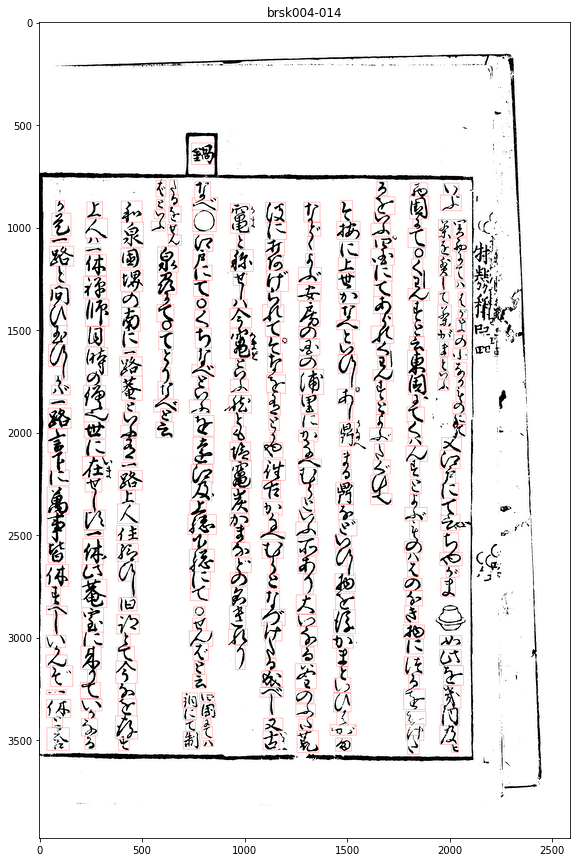

(2547, 3931)


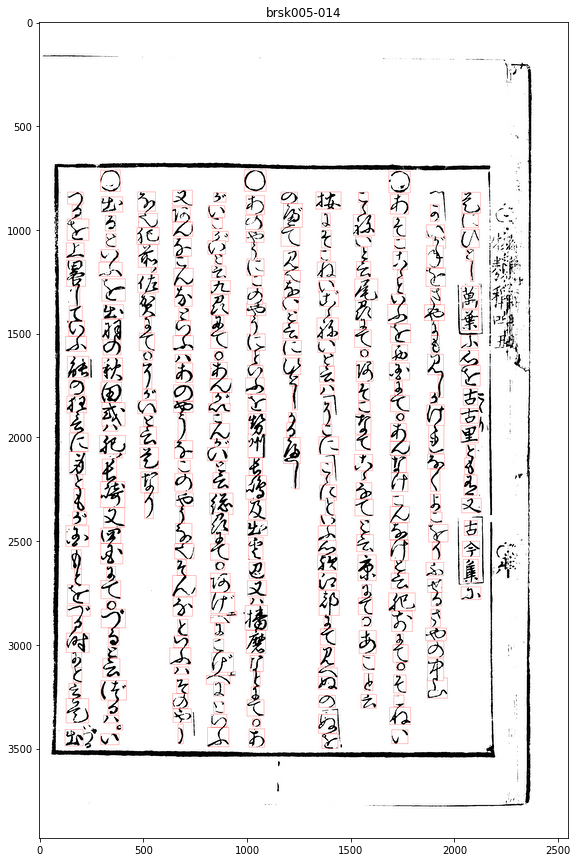

(2551, 3947)


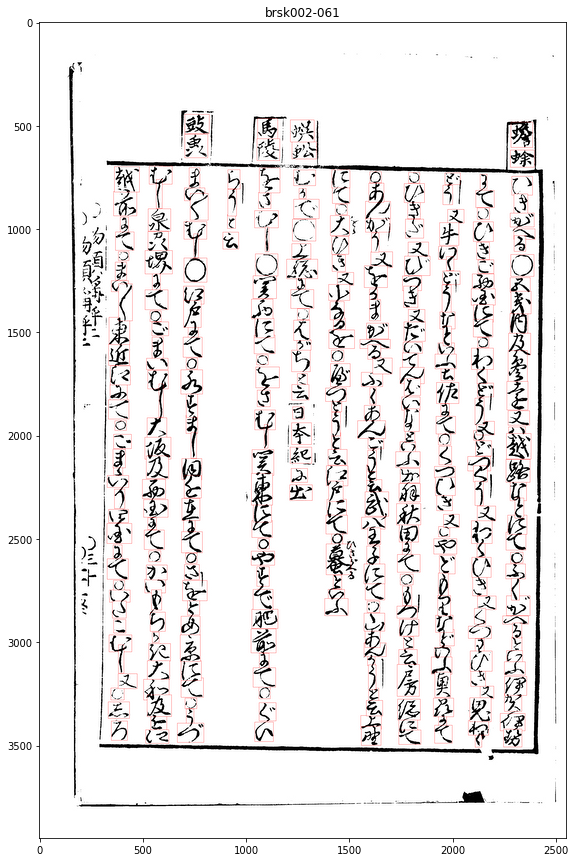

(2588, 3977)


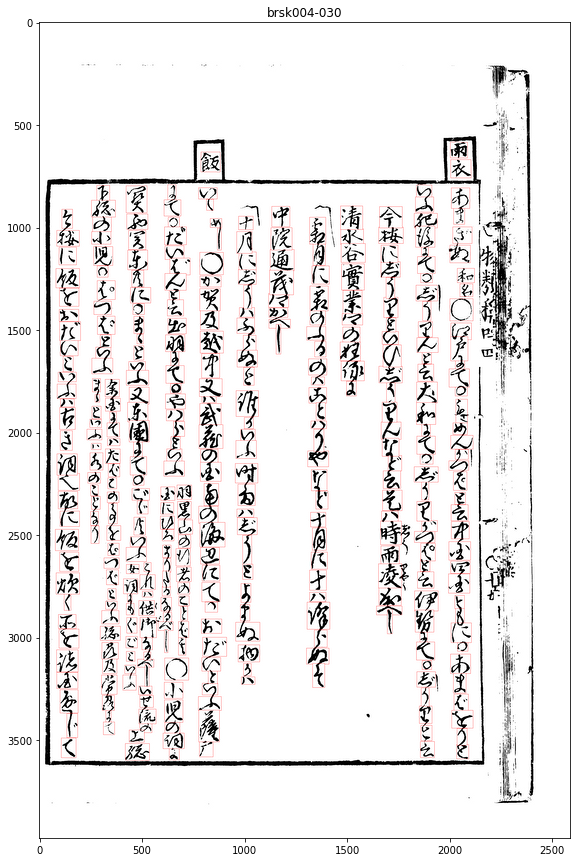

(2620, 3978)


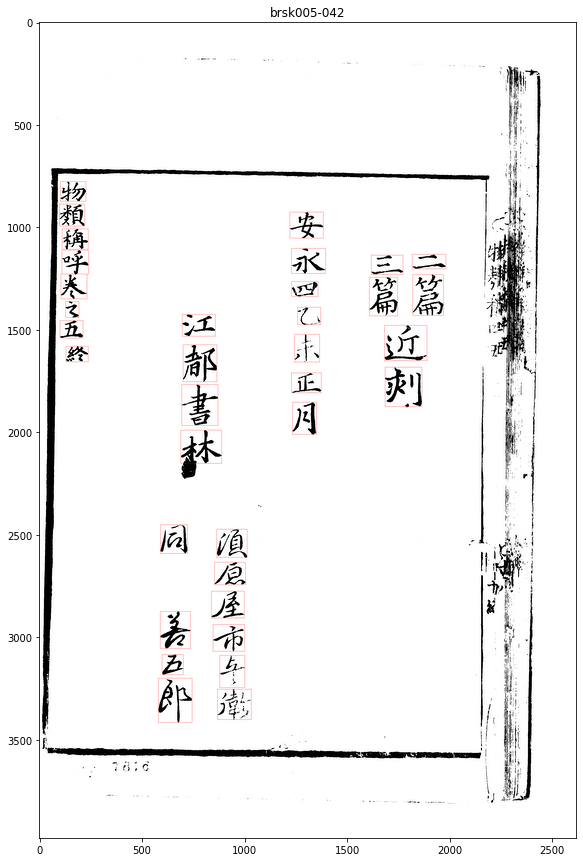

In [8]:
fontsize = 30
np.random.seed(1337)
#IMG 68 tiene mal delimitados los BBOX, por lo tanto se ha decicido excluirla, en lo que econtramos solucion~
#img= df_train['image_id'][8]
#label= df_train['labels'][8]
for i in range(5):
    img, labels = df_train.values[np.random.randint(len(df_train))]
    #img= df_train['image_id'][8]
    #label= df_train['labels'][8]
    
    viz = visualize_training_data('data/train_adaptive/{}.jpg'.format(img), labels)
    #viz = visualize_training_data('data/cropped/{}.jpg'.format(img), labels)
    
    plt.figure(figsize=(15, 15))
    plt.title(img)
    plt.imshow(viz, interpolation='lanczos')
    plt.show()